#### IMPORT DEPENDENCIES 

In [1]:
import sklearn 
import email
import numpy as np
import os
import pandas as pd
from bs4 import BeautifulSoup
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score,precision_score,recall_score, classification_report, f1_score,precision_recall_curve

#### DATA PRE-PROCESSING 

In [81]:
mailist = []
def data_tokenize(df):
    lemm = WordNetLemmatizer()
    for i in range(len(df)):
            rev = re.sub('[^a-zA-Z]',' ',df['mails'][i])
            rev = rev.lower()
            rev = rev.split()
            rev = [lemm.lemmatize(word) for word in rev if word not in set(stopwords.words('english'))]
            rev = ' '.join(rev)
            mailist.append(rev)

    cv = CountVectorizer(max_features =1000)
    x = cv.fit_transform(mailist).toarray()
    return x 


In [57]:
#spam no files = 1397
#easy spam = 2551
#hard ham = 250 
#total = 4198
mails = []

def clean_data(path):
    c = 0
    for file  in os.scandir(path):
        with open(file,'r',encoding='ISO-8859-1', errors = 'replace') as f:
            raw = f.read()
            msg = email.message_from_string(raw)
            if msg.is_multipart():
                for i in msg.walk():
                    j = i.get_content_type()
                    if j == 'text/plain':
                         data = i.get_payload(decode= True)
                    elif j == 'text/html':
                        cont =  i.get_payload(decode= True)
                        soup = BeautifulSoup(cont,'html.parser')
                        para = soup.get_text(strip=True)
                        data = para 


            else:
                if msg.get_content_type() == 'text/plain':
                    data = msg.get_payload(decode=True)
                else:
                    
                    html_cont = msg.get_payload(decode=True)
                    soup = BeautifulSoup(html_cont,'html.parser')
                    para = soup.get_text(strip=True)
                    data = para 
                
            if os.path.basename(path) == 'spam_2':
                label = 1 
            else:
                label= 0

            if isinstance(data,bytes):
                data = data.decode('ISO-8859-1')
            mails.append({'mails': data,'label':label })    
        
  
    return  mails


In [4]:
easy_ham= 'data/easy_ham/easy_ham'
hard_ham= 'data/hard_ham/hard_ham'
spam_ = 'data/spam_2/spam_2'

In [5]:
hham = clean_data(hard_ham)
eham = clean_data(easy_ham)
spam = clean_data(spam_)

Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


In [6]:
df_mails =pd.DataFrame(hham)
df_mails.head()

,mails,label
0,Cable companies cracking down on Wi-FiSearchNe...,0
1,Shopper Newsletter: AlertsLive tech help NOW!A...,0
2,"CNET | DOWNLOAD DISPATCH(Mac Edition)\nJuly 9,...",0
3,Today's Headlines from The Register\n---------...,0
4,20020709 Lockergnome Penguin Shell07.09.2002 P...,0


In [7]:
spam =df_mails['label'].value_counts()
ham =  df_mails[df_mails['label']==0].count()
lab = ['spam','ham']

<BarContainer object of 2 artists>

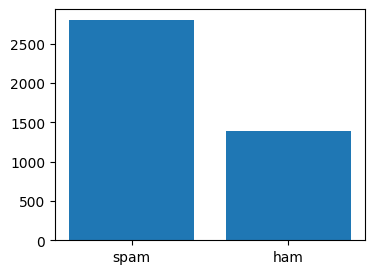

In [8]:
count = np.array([spam[0],spam[1]])
plt.figure(figsize=(4,3))
plt.bar(lab,count)

In [9]:
data_tokens = data_tokenize(df_mails)

In [10]:
df_tokens = pd.DataFrame(data_tokens)

In [11]:
df_tokens.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0,0,0,1,0,0,0,3,0,1,...,0,0,0,0,0,1,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
3,0,0,0,0,0,0,0,1,0,0,...,22,0,0,0,0,0,0,0,0,0
4,0,0,2,5,1,0,0,4,0,0,...,3,0,1,1,0,4,1,3,0,0


#### MODEL TRAINING 

In [83]:
X,x,Y,y = train_test_split(df_tokens,df_mails['label'], test_size = 0.2)

In [84]:
rf = RandomForestClassifier(n_estimators = 500, random_state=50)

In [85]:
rf.fit(X,Y)

RandomForestClassifier(n_estimators=500, random_state=50)

In [86]:
y_predictions = rf.predict(x)

#### MODEL EVALUATION

In [87]:
accuracy= accuracy_score(y,y_predictions)
precision = precision_score(y,y_predictions)
recall = recall_score(y,y_predictions)

In [88]:
conf_mat=confusion_matrix(y,y_predictions)

In [89]:
accuracy

0.9821428571428571

In [90]:
conf_mat

array([[548,   7],
       [  8, 277]], dtype=int64)

In [91]:
f1 = f1_score(y,y_predictions)
f1

0.9736379613356767

In [92]:
precision

0.9753521126760564

In [22]:
recall

0.9554455445544554

### Visualizing the Results

#### _Confusion Matrix_

<Axes: >

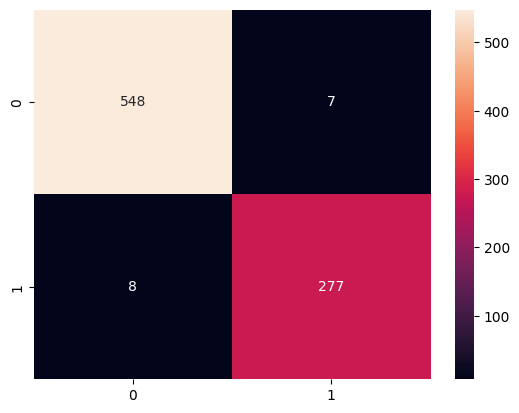

In [93]:
sns.heatmap(conf_mat,annot=True,fmt='d')

#### _Area Under Curve (AUC)_

In [94]:
p,r,_ = precision_recall_curve(y,y_predictions)

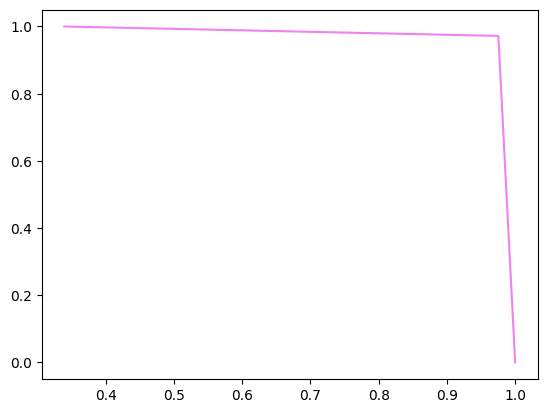

In [95]:
plt.plot(p,r,color='violet')

In [96]:
y = list(y)
y_predictions = list(y_predictions)

In [97]:
#list of all unique labels 
u = list(set(y+y_predictions))

#count of actual labels -0s and 1s in y 
a = [y.count(label) for label in u]

#count of predicted labels -0s and 1s in y_hat
p = [y_predictions.count(label) for label in u] 

#### Comparing Actual values to Predicted values

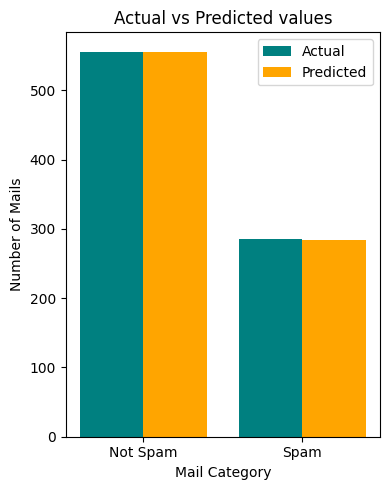

In [98]:
fig,ax = plt.subplots(figsize=(4,5))
b_width = 0.40
x = np.arange(len(u))
ax.bar(x - b_width/2, a , b_width ,label='Actual',color='teal')
ax.bar(x +b_width/2,p, b_width,label="Predicted",color='orange')
ax.set_xlabel("Mail Category")
ax.set_ylabel("Number of Mails")
ax.set_xticks(x)
ax.set_xticklabels(['Not Spam','Spam'])
ax.legend()
ax.set_title('Actual vs Predicted values')
plt.tight_layout()